# Visualize Variants

This notebook is meant for providing various kinds of visualizations for working with the SNP data

In [1]:
import sgkit as sg
from sgkit.io import plink
import pandas as pd
import numpy as np
import pickle
import math
import xarray as xr
import seaborn as sns
%matplotlib inline

## Load in Sgkit Dataset

In [4]:
with open('ds_known.pkl', 'rb') as handle:
    ds = pickle.load(handle)

## Run GWAS Linear Regression

In [5]:
traits = ['loco_maxcent', 'loco_maxdis', 'loco_maxrear', 'loco_maxact']
ds["call_dosage"] = ds.call_genotype.sum(dim="ploidy")
ds_lr = sg.gwas_linear_regression(ds, dosage="call_dosage", add_intercept=True, covariates=[], traits=traits)
ds_lr

<xarray.Dataset>
Dimensions:                      (variants: 8690, traits: 4, samples: 2368,
                                  alleles: 2, ploidy: 2)
Coordinates:
  * samples                      (samples) object '00077E61F3' ... 'E11DCD33DD'
Dimensions without coordinates: variants, traits, alleles, ploidy
Data variables: (12/20)
    variant_linreg_beta          (variants, traits) float64 dask.array<chunksize=(625, 4), meta=np.ndarray>
    variant_linreg_t_value       (variants, traits) float64 dask.array<chunksize=(625, 4), meta=np.ndarray>
    variant_linreg_p_value       (variants, traits) float64 dask.array<chunksize=(625, 4), meta=np.ndarray>
    call_alternate_allele_count  (variants, samples) int16 dask.array<chunksize=(625, 38), meta=np.ndarray>
    variant_contig               (variants) int16 0 0 0 0 0 0 ... 20 20 20 20 20
    variant_position             (variants) int32 dask.array<chunksize=(8690,), meta=np.ndarray>
    ...                           ...
    sample_phenotype             (samples) int8 dask.array<chunksize=(2368,), meta=np.ndarray>
    loco_maxcent                 (samples) float64 171.3 115.4 ... 117.6 180.0
    loco_maxdis                  (samples) float64 568.0 697.0 ... 534.0 550.0
    loco_maxrear                 (samples) float64 19.0 26.0 20.0 ... 31.0 28.0
    loco_maxact                  (samples) float64 109.0 135.0 ... 83.0 95.0
    call_dosage                  (variants, samples) int64 dask.array<chunksize=(625, 38), meta=np.ndarray>
Attributes:
    contigs:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',...
    source:   sgkit-0.6.0

In [8]:
def manhattan_plot(ds):
    df = ds[["variant_contig", "variant_position", "variant_linreg_p_value"]].to_dataframe()
    df["variant_linreg_log_p_value"] = -np.log10(df["variant_linreg_p_value"])
    df = df.astype({"variant_position": np.int64}) # to avoid overflow in cumulative_pos
    
    # from https://github.com/mojones/video_notebooks/blob/master/Manhattan%20plots%20in%20Python.ipynb, cell 20
    running_pos = 0
    cumulative_pos = []
    for chrom, group_df in df.groupby("variant_contig"):  
        cumulative_pos.append(group_df["variant_position"] + running_pos)
        running_pos += group_df["variant_position"].max()
    df["cumulative_pos"] = pd.concat(cumulative_pos)
    
    df["color group"] = df["variant_contig"].apply(lambda x : "A" if x % 2 == 0 else "B")
    
    g = sns.relplot(
        data = df,
        x = "cumulative_pos",
        y = "variant_linreg_log_p_value",
        hue = "color group",
        palette = ["blue", "orange"],
        linewidth=0,
        s=10,
        legend=None,
        aspect=3
    )
    g.ax.set_xlabel("Chromosome")
    g.ax.set_xticks(df.groupby("variant_contig")["cumulative_pos"].median())
    g.ax.set_xticklabels(df["variant_contig"].unique())
    g.ax.axhline(y = -math.log10(0.05), color='r', ls='-')
    g.ax.set_title("Significance of Association to 'loco' Phenotypes for all SNPs Across the Genome", fontsize = 14)

### Visualization 1

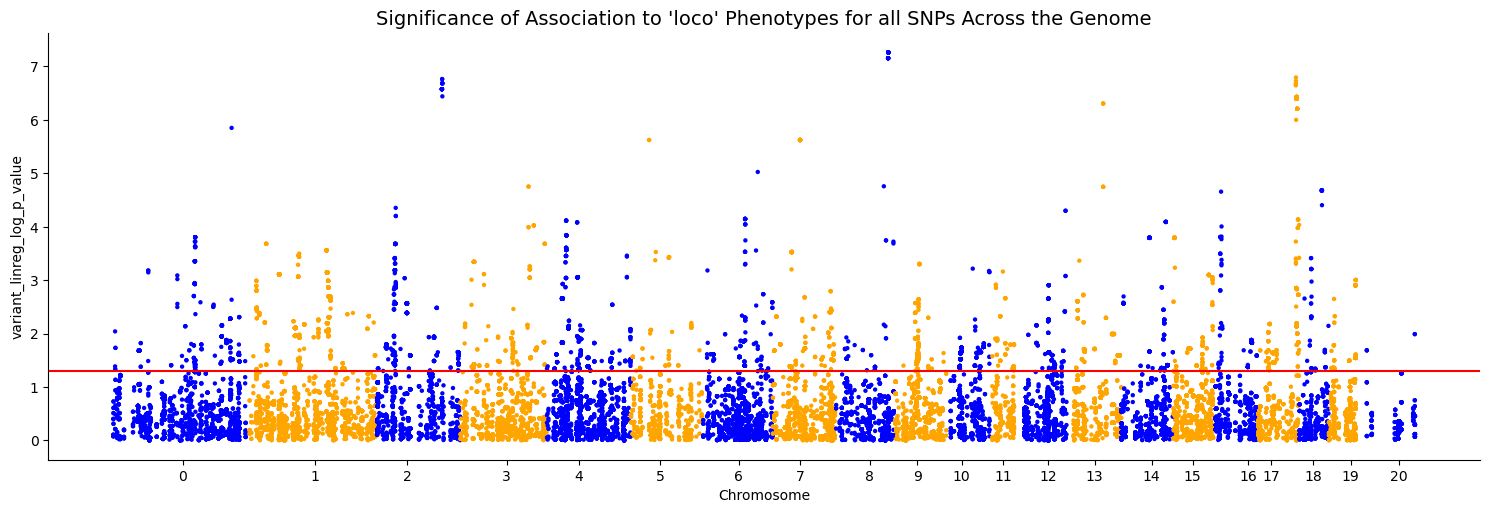

In [9]:
manhattan_plot(ds_lr)